# Lazy evaluation and graphs

## Imperative paradigm or just pure python

Doing a calculation in python is straight forward, for example as done below. While probably not conciously aware of it, this follows an imperative paradigm, what most programs do. Executing one line of code changes a value.

In [1]:
const_5 = 5
const_3 = 3
sum_5_3 = const_5 + const_3

const_7 = 7
const_2 = 2
sum_7_2 = const_7 + const_2

prod_sums = sum_5_3 * sum_7_2

We get an object out of the calculations:

In [2]:
prod_sums

72

Unfortunately, this was not efficient and we cannot deduce any more information form the output about it (like where it came from, equivalent to doing a simple physics exercise algebraicly versus directly entering the numbers into every variable)

## Declarative paradigm and Lazy evaluation

So it would be better, to "build" the calculation in the first place. Therefore, we need so-called "lazy evaluation", an object that first gets composed and run afterwards. This is a declarative programing style: we don't tell exactly what to do but rather what we wan't.



## Extension: Lazy evaluation in python

Let's do a very simple example of lazy evaluation (not really declarative actually) in python.

In [3]:
# Two equivalent ways of writing a function in python
def func():
    return 42
func = lambda: 42

In [4]:
const_5 = lambda: 5
const_3 = lambda: 3
sum_5_3 = lambda: const_5() + const_3()

const_7 = lambda: 7
const_2 = lambda: 2
sum_7_2 = lambda: const_7() + const_2()

prod_sums = lambda: sum_5_3() * sum_7_2()

And now we did not yet evaluate anything.

In [5]:
prod_sums

<function __main__.<lambda>()>

To evaluate this object, we simply call it:

In [6]:
prod_sums()

72

The advantage over the previous approach: we _could_ use the information stored in prod_sums to improve the calculation _before_ we run it.

In [7]:
import inspect
lines = inspect.getsource(prod_sums)
print(lines)

prod_sums = lambda: sum_5_3() * sum_7_2()



## Graphs

Of course, this was a simple example. Instead of setting up something like this, let's use an implementation: TensorFlow

In [8]:
import tensorflow as tf

In [9]:
const_5 = tf.constant(5.)
const_3 = tf.constant(3.)
sum_5_3 = tf.add(const_5, const_3)

# or even simpler
const_7 = tf.constant(7.)
const_2 = tf.constant(2.)
sum_7_2 = tf.add(const_7, const_2)

prod_sums = sum_5_3 * sum_7_2

In [10]:
prod_sums

<tf.Tensor 'mul:0' shape=() dtype=float32>

Before we hat a function, that was our lazy evaluatable object, now it's a Tensor. Names don't matter here. This looks like the following: ![graph structure visualized](images/graph_structure_addition.png)

To run it, instead of putting parenthesis around, we use something else

In [11]:
sess = tf.InteractiveSession()

In [12]:
prod_sums_number = sess.run(prod_sums)

In [13]:
prod_sums_number

72.0

### Extension: did we really build a graph?
Yes! Nothing else. Let's explore the graph

In [14]:
prod_sums  # output from the operation...

<tf.Tensor 'mul:0' shape=() dtype=float32>

In [15]:
prod_sums.op  # multiplies the inputs:

<tf.Operation 'mul' type=Mul>

In [16]:
prod_sums.op.inputs[:]  # with for example input 0 from the op..

[<tf.Tensor 'Add:0' shape=() dtype=float32>,
 <tf.Tensor 'Add_1:0' shape=() dtype=float32>]

In [17]:
prod_sums.op.inputs[0].op  # the first add with inputs

<tf.Operation 'Add' type=Add>

In [18]:
prod_sums.op.inputs[0].op.inputs[:]

[<tf.Tensor 'Const:0' shape=() dtype=float32>,
 <tf.Tensor 'Const_1:0' shape=() dtype=float32>]

We have the whole definition at hand! It is a simple matter of implementations to, for example, check if a value depends on another (by recursively searching its inputs if it is there).

### Automatic differentiation
A very useful thing we can get out is the gradient. Using the chain rule, TensorFlow is able to compute the derivative of **any** node with respect to **any** other node:

In [19]:
derivate_sum_by_const5 = tf.gradients(prod_sums, const_5)

In [20]:
derivate_sum_by_const5  # this is again a Tensor, an instruction how to do computation

[<tf.Tensor 'gradients/mul_grad/Mul:0' shape=() dtype=float32>]

In [21]:
sess.run(derivate_sum_by_const5)

[9.0]

Sidenote: this is taking the derivative of prod_sums with respect to the _node_ const_5 and _then_ evaluates this by inserting 5 into the node const_5.

## Using variables

The above is not yet very useful, since we cannot change the values of a node. What we want is a more general structure that allows to define e.g. a model that can be changed with parameters.

In [22]:
const_3 = tf.constant(2.)
var_1 = tf.Variable(name="variable1", initial_value=3., use_resource=True)
sess.run(var_1.initializer)  # just a thing needed to do, not important

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
# now create an operation as before
power_const_var = tf.pow(const_3, var_1)

In [24]:
sess.run(power_const_var)

8.0

In [25]:
# now let's change the value of the variable
var_1.load(4.)

In [26]:
# we can now either rerun the cell above or create a new cell here and enter the same command again.
# For illustrative purpose the second is done here
sess.run(power_const_var)

16.0

In [27]:
# and we can also take the derivative of course with respect to the variable
deriv_power_var = tf.gradients(power_const_var, var_1)

In [28]:
sess.run(deriv_power_var)  # W T F???

[11.090355]

Let's try to do a simple straight line fit.

In [62]:
# generating some data
n_events = 300
true_slope = np.random.uniform(0.3, 3)  # generate randomly a slope 
x_data = np.random.uniform(-100, 100, size=n_events)  # generate points between -100 and 100
y_clean = true_slope * x_data           # this is the function y = slope * x
y_data = y_clean + np.random.normal(0, 10, size=n_events)  # just adding some random noise

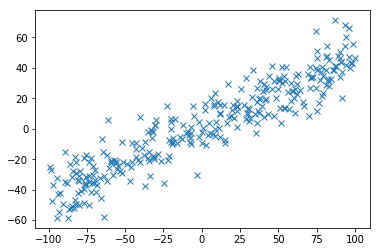

In [63]:
# to visualize the data
plt.plot(x_data, y_data, 'x')

In [64]:
# create the variable to be changed
slope = tf.Variable(name="slope", initial_value=1.)
sess.run(tf.global_variables_initializer())  # ignore line basically

# x_data_tf = tf.convert_to_tensor(x_data)
y = slope * x_data

# create a loss
squared_dist_loss = tf.reduce_sum(tf.square(y - y_data))

# since it can be useful, let's also create the instructions on how to compute the gradient
grad_slope = tf.gradients(squared_dist_loss, slope)[0]  # taking element 0 since it returns a list, not a scalar

## Playground minimization

Now we got everything: the instruction on how to compute the chi square loss and the parameter (`slope`) that changes our model. Use the two (three) cells below to minimize the loss and find the true slope.

***Exercise***: call the loss cell, then load a different value, see how it changes and repeat until you find the minimum of it. Hint: if you wanna run again, restart the notebook and run everything again. This will give you a new value for slope.

In [65]:
sess.run(squared_dist_loss)

348341.25

In [115]:
slope.load(1.299)

being smart, we can use the gradient information as well. Since it point into the direction of the steepest **ascent**, using the negative of it points into the direction of the **descent**. This tells us in which direction to change the parameter


In [116]:
sess.run(grad_slope)

1778670.9

In [117]:
# uncomment the below to see the true value
# true_slope

### Advanced: automatize the minimization

Why not create a while loop and automatize this? If you feel comfortable enough with the above and python, implement a loop. Hint: a criteria to stop the loop (convergence criteria) could be the absolute of the gradient. And don't make too big steps, rather too small ones.

In [118]:
# do your minimization here

## Changing our goal

We created a simple loss using the sum of the squared distances. However, we can create way more sophisticated losses by adding more terms to it. For example if we'd know that the slope is close to 1 (or take another number if your true slope is already close to 1), we can add an additional term that penalizes if `slope` is far away.

*(while Deep Learning uses the general expression of building a loss from components, in physics and fitting, this is usually called "adding a constraint to a parameter". There are many names for "the same")*

In [140]:
slope_we_assume = tf.constant(1.)  # any number within the boundaries [0.3, 3]
slope_constr = tf.square(500 * tf.subtract(slope, slope_we_assume))
squared_dist_constr = squared_dist_loss + slope_constr

We minimized by hand before (and it was cumbersome) but there are already pre-built minimizers (and in practice, we gonna **always** use them). So let's try one. There are a few different ones and some converge better for certain problems then others. In general, `Adam` performs overall very well.

In [141]:
optimizer = tf.train.AdamOptimizer(learning_rate=3.)  # here we create an instance of the optimizer, this needs to be done once

In [142]:
minimize_op = optimizer.minimize(squared_dist_constr)  # as before, this is also just an operation!
sess.run(tf.variables_initializer(optimizer.variables()))  # just a necessity, not important

In [143]:
# execute the minimization operation here
for _ in range(1000):
    sess.run(minimize_op)  # this is only one minimization step

In [144]:
# to check the value of the slope, we also need to run it
sess.run(slope)

0.55917877

In [145]:
# uncomment to see the true slope
true_slope

0.4488559077210695